In [93]:
'''
Final PRoject Report and Code
name: Wenxin Li
ID: 1007508724
'''

'\nFinal PRoject Report and Code\nname: Wenxin Li\nID: 1007508724\n'

In [2]:
!pip install plotly
!pip install pmdarima
!pip install statsmodels

In [3]:
import numpy as np, pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt, seaborn as sns
import scipy
import warnings
import plotly.express as px
from itertools import product
import statsmodels.api as sm
import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.preprocessing import PowerTransformer

#from google.colab import files
import io
from scipy.stats import mannwhitneyu
warnings.filterwarnings('ignore')

In [4]:
import statsmodels
print(statsmodels.__version__)

0.13.1


# Load the data set

In [5]:
# loading the dataset 
df = pd.read_csv('Covid19-vaccination.csv')
print('Shape of data',df.shape)
#see the first five of our dataframe
df.head()

Shape of data (63006, 16)


,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003


# 1. Data Cleaning
check out if we have any missing data in our dataset.

In [6]:
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                     27277
people_vaccinated                      28883
people_fully_vaccinated                31853
total_boosters                         56393
daily_vaccinations_raw                 33083
daily_vaccinations                       326
total_vaccinations_per_hundred         27277
people_vaccinated_per_hundred          28883
people_fully_vaccinated_per_hundred    31853
total_boosters_per_hundred             56393
daily_vaccinations_per_million           326
daily_people_vaccinated                 1558
daily_people_vaccinated_per_hundred     1558
dtype: int64

I drop total_vaccinations missing data, because without this value any raw doesn't make much sense.

In [7]:
df_clean = df.drop(df[df.total_vaccinations.isna()].index)
df_clean.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                       1879
people_fully_vaccinated                 4751
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

## people_vaccinated

Use pd.Dataframe.corr() and Mann-Whitney U test to check out which features have the same distribution with people_vaccinated.
And first, we need to drop all the NA in the people_vaccinated and its compared features.

In [8]:
check_df = df.drop(df[df.total_vaccinations.isna()].index)
check_df = check_df.drop(check_df[check_df.people_vaccinated.isna()].index)
check_df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN
6,Afghanistan,AFG,2021-02-28,8200.0,8200.0,NaN,NaN,NaN,1367.0,0.02,0.02,NaN,NaN,34.0,1367.0,0.003
22,Afghanistan,AFG,2021-03-16,54000.0,54000.0,NaN,NaN,NaN,2862.0,0.14,0.14,NaN,NaN,72.0,2862.0,0.007
44,Afghanistan,AFG,2021-04-07,120000.0,120000.0,NaN,NaN,NaN,3000.0,0.30,0.30,NaN,NaN,75.0,3000.0,0.008
59,Afghanistan,AFG,2021-04-22,240000.0,240000.0,NaN,NaN,NaN,8000.0,0.60,0.60,NaN,NaN,201.0,8000.0,0.020


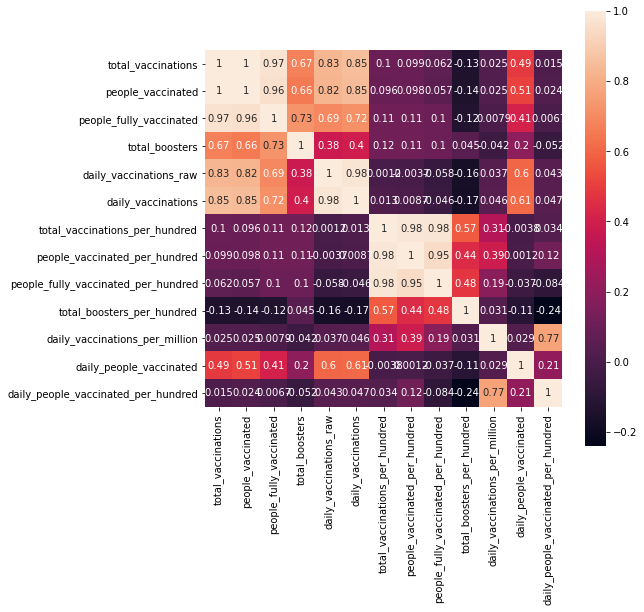

In [9]:
plt.subplots(figsize=(8, 8))
sns.heatmap(check_df.corr(), annot=True, square=True)
plt.show()

In [10]:
#pair of total_vaccinations & people_vaccinated 
mannwhitneyu(check_df.people_vaccinated,check_df.total_vaccinations)

MannwhitneyuResult(statistic=523806931.0, pvalue=4.1602872837396384e-83)

According to p value of total_vaccinations & people_vaccinated is lower than 0.05, I cannot find the same distribution between total_vaccinations and people_vaccinated. So, use 0 to fill NA in people_vaccinated. 

In [11]:
df_clean.people_vaccinated = df_clean.people_vaccinated.fillna(0)

In [12]:
df_clean.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                          0
people_fully_vaccinated                 4751
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

## people_fully_vaccinated

Delete all NA in people_fully_vaccinated and its relevant columns(total_vaccinations and people_vaccinated) and check the p_value 

In [13]:
#pair of total_vaccinations & people_fully_vaccinated
check_df = df.drop(df[df.total_vaccinations.isna()].index)
check_df = check_df.drop(check_df[check_df.people_fully_vaccinated.isna()].index)
mannwhitneyu(check_df.total_vaccinations,check_df.people_fully_vaccinated)

MannwhitneyuResult(statistic=592928748.5, pvalue=0.0)

In [14]:
#pair of people_vaccinated & people_fully_vaccinated
check_df = df.drop(df[df.people_vaccinated.isna()].index)
check_df = check_df.drop(check_df[check_df.people_fully_vaccinated.isna()].index)
mannwhitneyu(check_df.people_vaccinated,check_df.people_fully_vaccinated)

MannwhitneyuResult(statistic=544923038.0, pvalue=3.560451063057542e-224)

According to p value of total_vaccinations & people_fully_vaccinated and p value of people_vaccinated & people_fully_vaccinated are both lower than 0.05, I cannot find the same distribution among total_vaccinations,people_vaccinated, and people_fully_vaccinated. 
So, use 0 to fill NA in people_fully_vaccinated.

In [15]:
df_clean.people_fully_vaccinated = df_clean.people_fully_vaccinated.fillna(0)

In [16]:
df_clean.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                          0
people_fully_vaccinated                    0
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

## daily_vaccinations_raw & daily_vaccinations

According to the heatmap, daily_vaccinations_raw get a high correlation with daily_vaccinations, I check the p value between them.

In [17]:
#pair of daily_vaccinations_raw & daily_vaccinations
check_df = df.drop(df[df.daily_vaccinations_raw.isna()].index)
check_df = check_df.drop(check_df[check_df.daily_vaccinations.isna()].index)
mannwhitneyu(check_df.daily_vaccinations_raw,check_df.daily_vaccinations)

MannwhitneyuResult(statistic=436662889.5, pvalue=1.7924498806068453e-07)

p_value of daily_vaccinations_raw & daily_vaccinations is 1.7924498806068453e-07 lower than 0.05 which means the hypothesis doesn't hold. The distribution between daily_vaccinations_raw and daily_vaccinations is different. So, I use 0 to fill NA in daily_vaccinations_raw and daily_vaccinations.

In [18]:
df_clean.daily_vaccinations_raw = df_clean.daily_vaccinations_raw.fillna(0)
df_clean.daily_vaccinations = df_clean.daily_vaccinations.fillna(0)

In [19]:
df_clean.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                          0
people_fully_vaccinated                    0
total_boosters                         29169
daily_vaccinations_raw                     0
daily_vaccinations                         0
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

## people_vaccinated_per_hundred

In [20]:
#pair of total_vaccinations_per_hundred & people_vaccinated_per_hundred
check_df = df.drop(df[df.total_vaccinations_per_hundred.isna()].index)
check_df = check_df.drop(check_df[check_df.people_vaccinated_per_hundred.isna()].index)
mannwhitneyu(check_df.total_vaccinations_per_hundred,check_df.people_vaccinated_per_hundred)

MannwhitneyuResult(statistic=693196150.5, pvalue=0.0)

According to p_value of total_vaccinations_per_hundred & people_vaccinated_per_hundred is 0 (lower than 0.05), hypothesis between these two features doesn't hold. The distribution between daily_vaccinations_raw and daily_vaccinations is different. So, I use 0 to fill NA in people_vaccinated_per_hundred.

In [21]:
df_clean.people_vaccinated_per_hundred = df_clean.people_vaccinated_per_hundred.fillna(0)

In [22]:
df_clean.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                          0
people_fully_vaccinated                    0
total_boosters                         29169
daily_vaccinations_raw                     0
daily_vaccinations                         0
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred              0
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

## people_fully_vaccinated_per_hundred

In [23]:
# pair of total_vaccinations_per_hundred & people_fully_vaccinated_per_hundred
check_df = df.drop(df[df.total_vaccinations_per_hundred.isna()].index)
check_df = check_df.drop(check_df[check_df.people_fully_vaccinated_per_hundred.isna()].index)
mannwhitneyu(check_df.total_vaccinations_per_hundred,check_df.people_fully_vaccinated_per_hundred)

MannwhitneyuResult(statistic=672019225.0, pvalue=0.0)

In [24]:
# pair of people_vaccinated_per_hundred & people_fully_vaccinated_per_hundred
check_df = df.drop(df[df.people_vaccinated_per_hundred.isna()].index)
check_df = check_df.drop(check_df[check_df.people_fully_vaccinated_per_hundred.isna()].index)
mannwhitneyu(check_df.people_vaccinated_per_hundred,check_df.people_fully_vaccinated_per_hundred)

MannwhitneyuResult(statistic=579247371.0, pvalue=0.0)

P_value of total_vaccinations_per_hundred & people_fully_vaccinated_per_hundred and people_vaccinated_per_hundred & people_fully_vaccinated_per_hundred are both 0, the distribution among these three features are different. Fill NA with 0 in people_fully_vaccinated_per_hundred.

In [25]:
df_clean.people_fully_vaccinated_per_hundred = df_clean.people_fully_vaccinated_per_hundred.fillna(0)

In [26]:
df_clean.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                          0
people_fully_vaccinated                    0
total_boosters                         29169
daily_vaccinations_raw                     0
daily_vaccinations                         0
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred              0
people_fully_vaccinated_per_hundred        0
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

## Other Features

These features they have no correlate columns(corr() is higher than 0.9) in heatmap, directly fill NA with 0 in chese columns.

In [27]:
#fill NA with 0 in these features
df_clean.total_boosters = df_clean.total_boosters.fillna(0)
df_clean.total_boosters_per_hundred = df_clean.total_boosters_per_hundred.fillna(0)
df_clean.daily_vaccinations_per_million = df_clean.daily_vaccinations_per_million.fillna(0)
df_clean.daily_people_vaccinated = df_clean.daily_people_vaccinated.fillna(0)
df_clean.daily_people_vaccinated_per_hundred = df_clean.daily_people_vaccinated_per_hundred.fillna(0)

In [28]:
#final check whether still have NA in each column
df_clean.isna().sum()

location                               0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
total_boosters                         0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
total_boosters_per_hundred             0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
dtype: int64

# 2. Data Visualization and Exploratory Data Analysis 

## 2.1 Top 10 most vaccinated countries

In [29]:
#check location type in the datasset
df_clean.location.value_counts().head(20)

World                  356
Europe                 356
High income            356
Norway                 351
European Union         345
North America          344
United States          344
Canada                 343
Latvia                 343
Asia                   339
Israel                 338
Switzerland            336
Liechtenstein          336
Upper middle income    333
South America          333
Chile                  332
Lithuania              330
Czechia                330
Estonia                330
Slovenia               330
Name: location, dtype: int64

According to the location table, I find out that there are three different types of locations which are countries, income level, and continents. I need first delete income level and continents, then I can get top 10 most vaccinated countries.

In [30]:
# Groupby df location and then sorting the data by the max value of people_vaccinated from highest to lowest
top_total_vaccinations = df_clean.groupby('location').people_vaccinated.max().sort_values(ascending=False)
total_vaccinations_f = top_total_vaccinations.dropna(axis=0).reset_index() # Dropping NaN values
display(total_vaccinations_f.head(15))

,location,people_vaccinated
0,World,4.197512e+09
1,Asia,2.882381e+09
2,Upper middle income,1.883448e+09
3,Lower middle income,1.390193e+09
4,China,1.225000e+09
5,High income,8.904829e+08
6,India,7.669880e+08
7,Europe,4.622119e+08
8,North America,3.780404e+08
9,European Union,3.131338e+08


In [31]:
#delete all index of World,income level, and continents and display top 10 locatios again
total_vaccinations_f = total_vaccinations_f.drop(index = [0,1,2,3,5,7,8,9,10,13]).reset_index().drop(columns='index')
display(total_vaccinations_f.head(10))

,location,people_vaccinated
0,China,1.225000e+09
1,India,7.669880e+08
2,United States,2.302987e+08
3,Brazil,1.624368e+08
4,Indonesia,1.344183e+08
5,Japan,9.954649e+07
6,Pakistan,7.884517e+07
7,Mexico,7.586211e+07
8,Vietnam,6.670689e+07
9,Russia,6.349654e+07


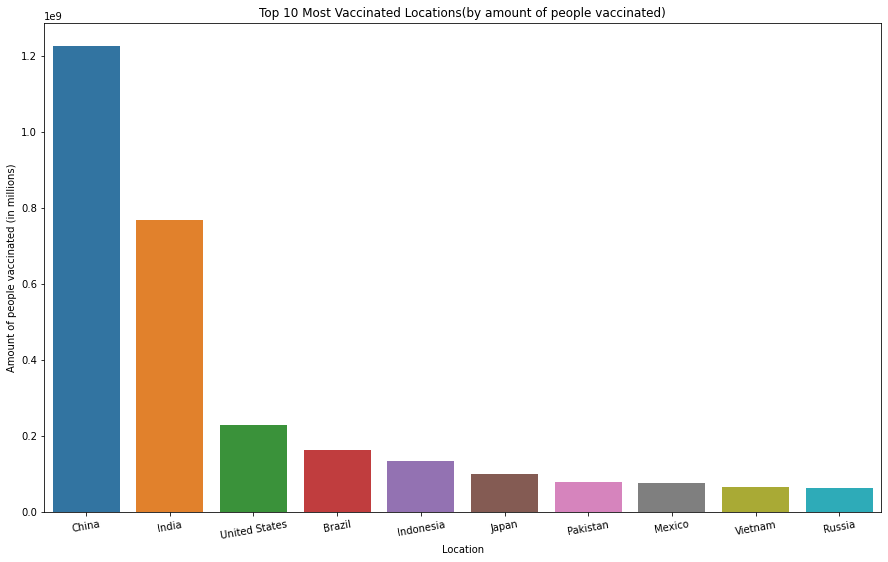

In [32]:
# Plotting a barplot for data viz using matplotlib and seaborn
plt.figure(figsize=(15, 9))
plt.title('Top 10 Most Vaccinated Locations(by amount of people vaccinated)')
sns.barplot(x=total_vaccinations_f.location[0:10], y=total_vaccinations_f['people_vaccinated'])
plt.xlabel('Location')
plt.xticks(rotation=10)
plt.ylabel('Amount of people vaccinated (in millions)');

Observing the figure, we can find that the number of total vaccinations in the first two countries, China and India, is much larger than that of other countries. But because these two countries also have a large population, this may lead to a high maximum population vaccination value. I need to continue to explore the details of vaccine expansion to check whether the vaccination plans in these two countries are really good.

## 2.2 Which locations have the most effective vaccination programme?

In [33]:
# Grouping the data by country and then sorting the data by the max value from highest to lowest
top_daily = df_clean.groupby('location').daily_vaccinations.max().sort_values(ascending=False)
top_daily_f = top_daily.dropna(axis='rows').reset_index() # Dropping NaN values
display(top_daily_f.head(20))

,location,daily_vaccinations
0,World,43233999.0
1,Asia,33335736.0
2,Upper middle income,27439252.0
3,China,22424286.0
4,Lower middle income,16674499.0
5,India,10037995.0
6,High income,8397153.0
7,Europe,5128678.0
8,North America,4173238.0
9,European Union,4075834.0


In [34]:
#delete all index of World,income level, and continents and display top 10 locatios again
top_daily_f = top_daily_f.drop(index = [0,1,2,4,6,7,8,9,10,13]).reset_index().drop(columns='index')
display(top_daily_f.head(10))

,location,daily_vaccinations
0,China,22424286.0
1,India,10037995.0
2,United States,3499189.0
3,Brazil,2595170.0
4,Japan,1997542.0
5,Indonesia,1901294.0
6,Mexico,1648223.0
7,Vietnam,1632517.0
8,Bangladesh,1502924.0
9,Pakistan,1280906.0


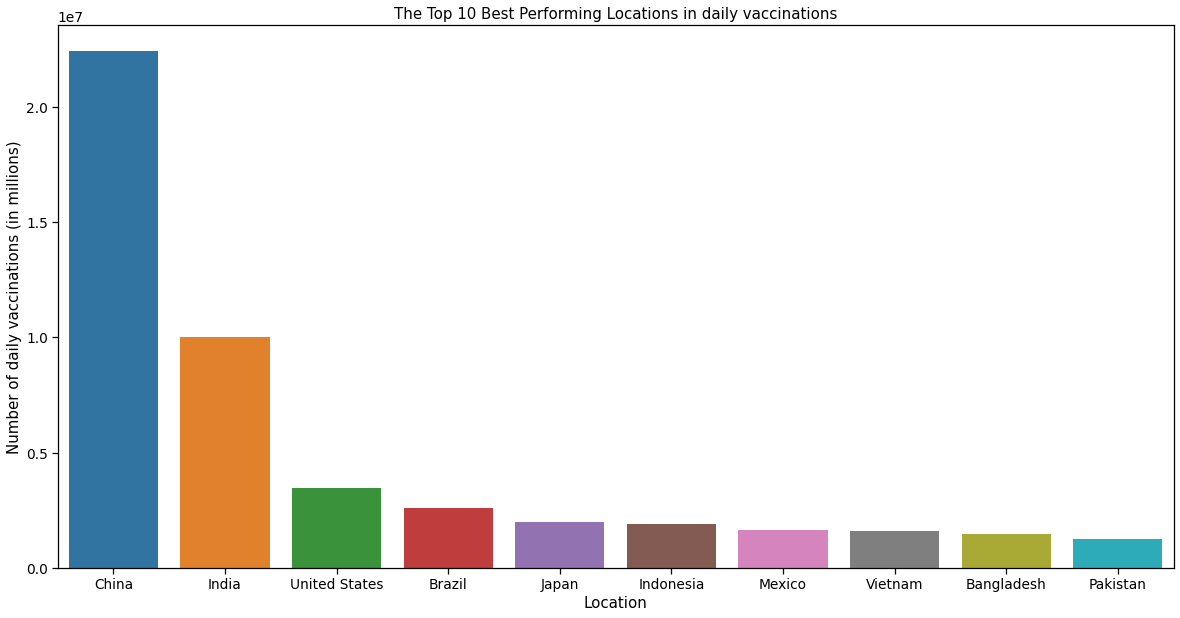

In [35]:
# Plotting the data
with sns.plotting_context('notebook', font_scale = 1.25):
    plt.figure(figsize=(20, 10))
    plt.title('The Top 10 Best Performing Locations in daily vaccinations')
    sns.barplot(x=top_daily_f.location[0:10], y=top_daily_f.daily_vaccinations[0:10])
    plt.xlabel('Location')
    plt.ylabel('Number of daily vaccinations (in millions)');

This figure is very close to the previous figure. The first four countries are exactly the same. The difference is that the positions of Indonesia and Japan have changed. In addition, Bangladesh, instead of Russia, entered the top 10 countries in this figure.
With this result, we can know that the countries that have a large population do have an effective vaccination program. 

## 2.3 Top 10 locations have the most people fully vaccinated per hundred 

Knowing that countries with more vaccinations also have effective vaccine plans, we also want to know the country’s vaccination ratio. Do these vaccinated countries have a high rate of vaccination?

In order to solve this problem, I need to analyze the data of people_fully_vaccinated_per_hundred.

In [36]:
# Grouping the data by locations and then sorting the data by the max value of people_fully_vaccinated_per_hundred from highest to lowest
top_fully_per_hundred = df_clean.groupby('location').people_fully_vaccinated_per_hundred.max().sort_values(ascending=False)
top_fully_per_hundred_f = top_fully_per_hundred.dropna(axis='rows').reset_index() # Dropping NaN values
display(top_fully_per_hundred_f.head(10))

,location,people_fully_vaccinated_per_hundred
0,Gibraltar,118.18
1,Pitcairn,100.00
2,Singapore,91.91
3,United Arab Emirates,88.40
4,Portugal,87.78
5,Malta,83.59
6,Chile,82.97
7,Cayman Islands,82.95
8,Iceland,81.56
9,Spain,80.26


According to the top 10 table, we can see that the value of Gibraltar is larger than 100 which is not reasonable. So, I delete this location in our dataset.

In [37]:
#delete Gibraltar
top_fully_per_hundred_f = top_fully_per_hundred_f.drop(index=0).reset_index()

In [38]:
#display top 10 people_fully_vaccinated_per_hundred again.
display(top_fully_per_hundred_f.head(10))

,index,location,people_fully_vaccinated_per_hundred
0,1,Pitcairn,100.00
1,2,Singapore,91.91
2,3,United Arab Emirates,88.40
3,4,Portugal,87.78
4,5,Malta,83.59
5,6,Chile,82.97
6,7,Cayman Islands,82.95
7,8,Iceland,81.56
8,9,Spain,80.26
9,10,Cuba,79.82


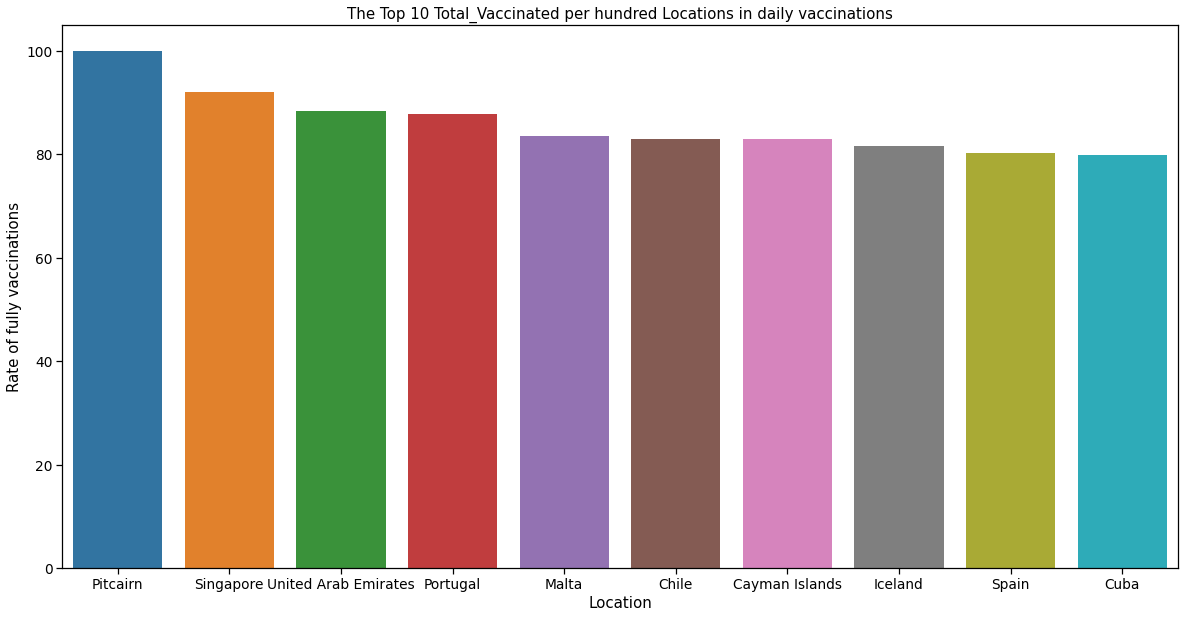

In [39]:
# Plotting the data
with sns.plotting_context('notebook', font_scale = 1.25):
    plt.figure(figsize=(20, 10))
    plt.title('The Top 10 Total_Vaccinated per hundred Locations in daily vaccinations')
    sns.barplot(x=top_fully_per_hundred_f.location[0:10], y=top_fully_per_hundred_f.people_fully_vaccinated_per_hundred[0:10])
    plt.xlabel('Location')
    plt.ylabel('Rate of fully vaccinations');

The 10 countries with the highest complete vaccination rates per 100 people differ from the 10 countries with the most effective vaccination schedules and the 10 countries with the highest vaccination rates. This means that the percentage of fully vaccinated people per 100 people in the most vaccinated and best performing countries is not high. 

## 2.4 The progression in daily vaccinations over time

In part 2.2 I already know the max value of daily vaccinations, but I still want to know how fast these countries can get its maximum value.

In [40]:
# Establishing which columns are relevant and preparing the dataset
cols = ['location', 'date', 'daily_vaccinations']
covid_df = df_clean.reset_index()

# Creating a list of the aforementioned best performing countries in terms of daily vaccinations
top_10_locations = list(top_daily_f.location[0:10].values)

# Filtering and sorting the data
daily_vacc_df = covid_df[['location', 'date', 'daily_vaccinations']].sort_values(by='daily_vaccinations', ascending=True)
top_10_dv_df = daily_vacc_df[daily_vacc_df.location.isin(top_10_locations)].dropna()

display(top_10_dv_df) # verifying that the filtering executed correctly

,location,date,daily_vaccinations
14083,India,2021-01-15,0.0
14383,Indonesia,2021-01-12,0.0
15989,Japan,2021-02-17,0.0
20645,Mexico,2020-12-24,0.0
5948,China,2020-12-15,0.0
...,...,...,...
6059,China,2021-06-29,21993000.0
6054,China,2021-06-24,21998714.0
6056,China,2021-06-26,22105857.0
6057,China,2021-06-27,22366286.0


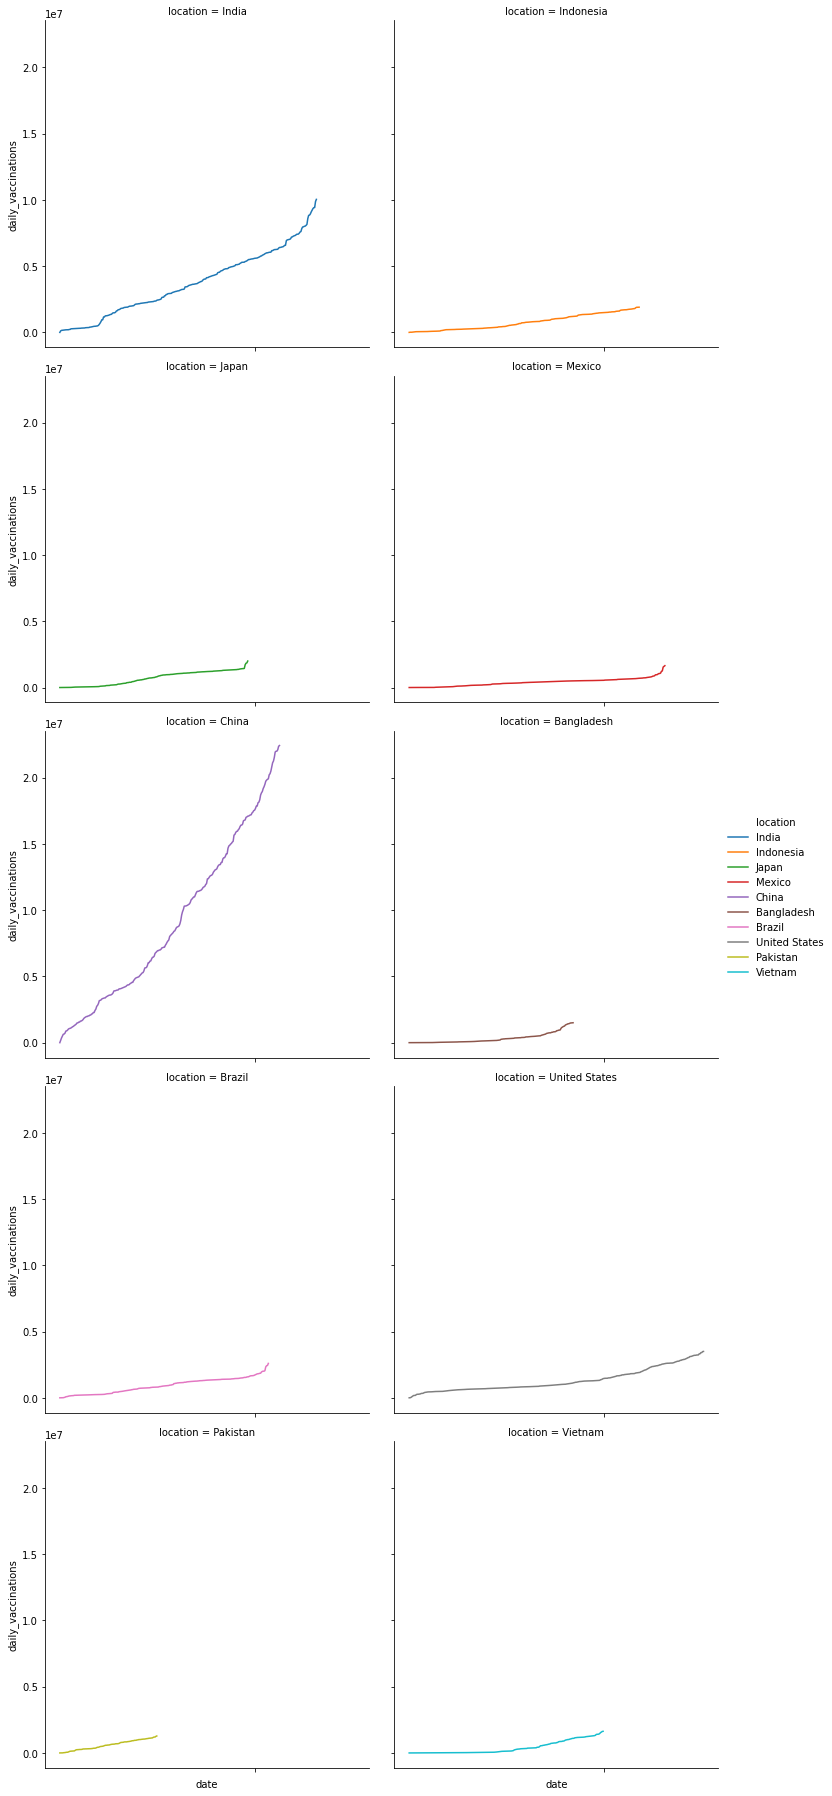

In [41]:
# Plotting the data in a multi faceted lineplot

#plt.figure(figsize=(18, 32))
sns.relplot(data=top_10_dv_df, x='date', y='daily_vaccinations', hue='location', col='location', kind='line', col_wrap=2)
plt.xticks('');

According to the upward trend, it can be found that China has the fastest rising speed, followed by the upward trends of India and the United States.

According to the timeline, it can be found that the trend graphs of Bangladesh, Pakistan, and Vietnam are shorter than those of other countries. It may be that the data is correct, but the bigger reason is that with the development of the epidemic, the vaccine supply in some countries is insufficient. The reason for this judgment is that the number of daily vaccinations in countries that can produce vaccines in their own countries is gradually increasing and there is no interruption.

# 3. Model selection and fitting to data 

In [42]:
#Create new columns based on distinct values and count them
df_clean = df_clean.sort_values('location')
df_clean['eid'] = (df_clean.groupby(['location']).cumcount()==0).astype(int)
df_clean['eid'] = df_clean['eid'].cumsum()

## Model Selection

Since the data set is a time series, we need to use a time-series correlation model. Among these models, I choose ARIMA as my model, which combines the AR and MA improved time models. Also, it can meet the differential requirements and has a wider range of adaptability of the dataset.

Since the goal is to predict the number of people vaccinated in each country in the next 50 days, I choose the column of 'people_vaccinated' as the best dataset of the model. The reason is that this column show directly the numbers of people vaccinated. The number of people vaccinated in each country in the next 50 days we want can get by the number of the ending day minus the number of the beginning day.

## Canada

In [43]:
#Country 1: Canada
ndf_can=df_clean.loc[df_clean['eid'] == 38]
df_can = ndf_can.sort_values('people_vaccinated')
df_can

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,eid
9795,Canada,CAN,2020-12-14,5.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,38
9796,Canada,CAN,2020-12-15,727.0,727.0,0.0,0.0,722.0,722.0,0.00,0.00,0.00,0.00,19.0,722.0,0.002,38
9797,Canada,CAN,2020-12-16,3016.0,3016.0,0.0,0.0,2289.0,1506.0,0.01,0.01,0.00,0.00,40.0,1506.0,0.004,38
9798,Canada,CAN,2020-12-17,7267.0,7267.0,0.0,0.0,4251.0,2421.0,0.02,0.02,0.00,0.00,64.0,2421.0,0.006,38
9799,Canada,CAN,2020-12-18,11276.0,11276.0,0.0,0.0,4009.0,2818.0,0.03,0.03,0.00,0.00,74.0,2818.0,0.007,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10133,Canada,CAN,2021-11-17,59776509.0,30102545.0,28764923.0,909041.0,76112.0,61164.0,157.03,79.08,75.56,2.39,1607.0,14376.0,0.038,38
10134,Canada,CAN,2021-11-18,59852559.0,30121803.0,28795770.0,934986.0,76050.0,66659.0,157.23,79.13,75.64,2.46,1751.0,15696.0,0.041,38
10135,Canada,CAN,2021-11-19,59918117.0,30136287.0,28821607.0,960223.0,65558.0,62649.0,157.40,79.16,75.71,2.52,1646.0,14717.0,0.039,38
10136,Canada,CAN,2021-11-20,59947684.0,30145291.0,28837538.0,964855.0,29567.0,62168.0,157.48,79.19,75.75,2.53,1633.0,14706.0,0.039,38


In [44]:
#Get the values from the column where vaccination rate of Canada (or country of your choice) is stored.
val_can = df_can['people_vaccinated'].values

In [45]:
#find best p,d,q by auto_arima
model = pm.auto_arima(val_can, trace=True, suppress_warning=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=7923.726, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7984.420, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=7964.708, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=7941.855, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=7924.624, Time=0.18 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=7929.502, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=7925.248, Time=0.40 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=7876.765, Time=0.75 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=7927.955, Time=0.26 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=7865.094, Time=0.79 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=inf, Time=1.19 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=7895.087, Time=0.43 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=7884.583, Time=0.59 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=7835.276, Time=0.87 sec
 ARIMA(4,2,1)(0,0,0)[0]             : 

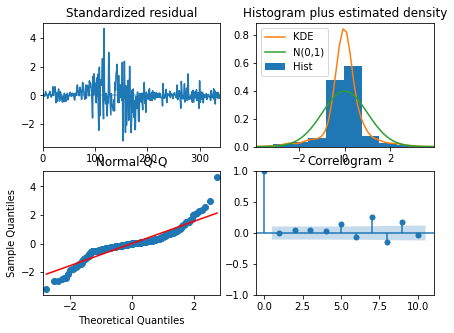

In [46]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

Observing the residual plots, I can know that the residuals fluctuate around 0 mean. Observing the residual density distribution graph, it can be found that its distribution is similar to a normal distribution with a mean value of zero. The picture in the lower left corner tells me that only the points at the two ends are slightly off. The autocorrelation graph in the lower right corner shows that there is no obvious pattern inside the residual. 

The above conclusion tells us that this model is very suitable for this data.

Now I can use this model to predict the value of the next 50 days.

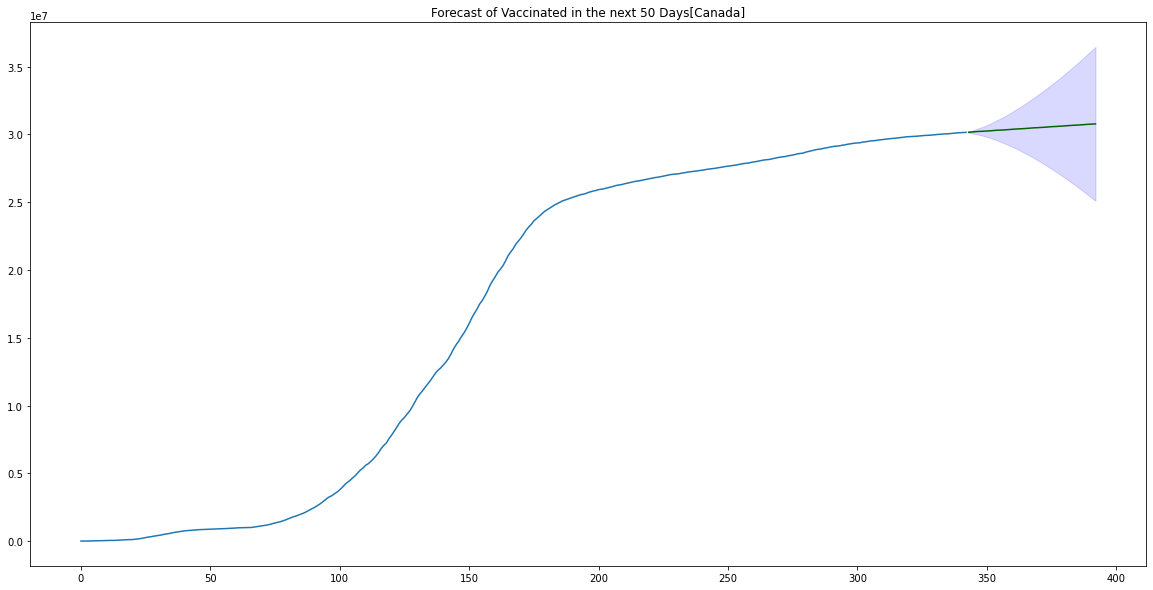

In [47]:
# Forecast（alpha=0.05 CI=0.95）
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(val_can), len(val_can)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(20,10))
plt.plot(val_can)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,lower_series,upper_series,color='b', alpha=.15)
plt.title("Forecast of Vaccinated in the next 50 Days[Canada]")
plt.show()

When the confidence interval is 0.95, I find that the lower series have negative predictions. This is an unreasonable prediction because the number of vaccinated people will only increase but not decrease. Therefore, I need to increase the value of alpha (decrease the confidence interval) to avoid negative predictions.

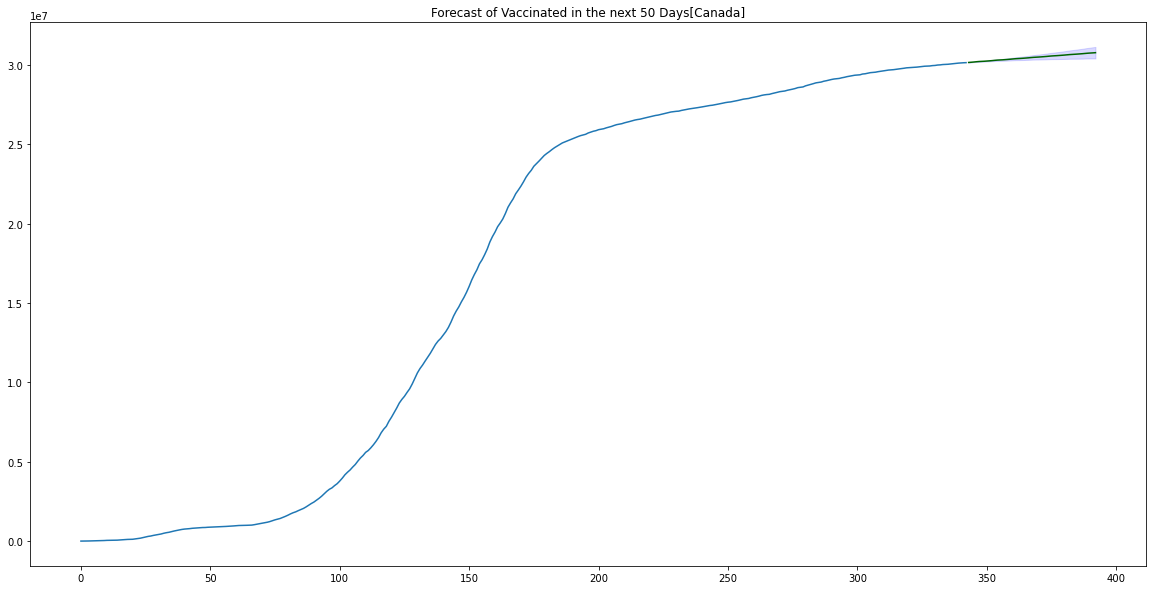

In [48]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.9)
index_of_fc = np.arange(len(val_can), len(val_can)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(20,10))
plt.plot(val_can)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,lower_series,upper_series,color='b', alpha=.15)
plt.title("Forecast of Vaccinated in the next 50 Days[Canada]")
plt.show()

In order to get a better model, I perform a power transformation on the data, the method is box cox transform. Then use the inverse transform to get the original data after the prediction is completed. The advantage of this is that the variance of the data can be stabilized.

In [49]:
#Power Transformer
power = PowerTransformer(method='box-cox')
can_trans = power.fit_transform(val_can[val_can>0].reshape(-1,1))
model = pm.auto_arima(can_trans, trace=True, suppress_warning=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-3015.206, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-2974.278, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-2985.001, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-2994.321, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-3017.572, Time=0.24 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-3023.627, Time=0.14 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-3021.304, Time=0.36 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-3015.257, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-2963.185, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-3022.152, Time=0.19 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 1.924 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  343
Model:               SARIMAX(0, 2, 2)   Log Likeliho

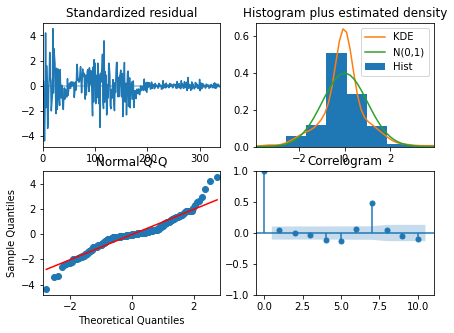

In [50]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

By observing plot_diagnostics, it can be found that the residual density distribution obtained by the power-transformed model is closer to the normal distribution with a mean value of zero and has fewer autocorrelation patterns. The model is optimized. 

I will use this optimization model to predit the value of the next 50 days.

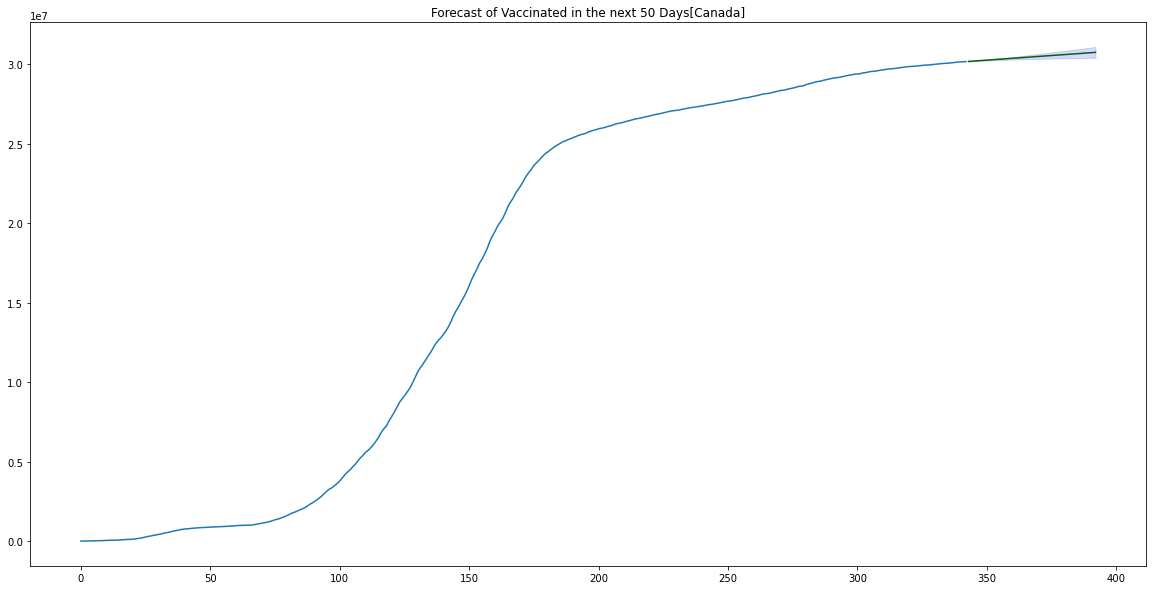

In [51]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.95)
index_of_fc = np.arange(len(val_can), len(val_can)+n_periods)
fc = power.inverse_transform(fc.reshape(-1,1)).flatten()
lower = power.inverse_transform(confint[:, 0].reshape(-1,1)).flatten()
upper = power.inverse_transform(confint[:, 1].reshape(-1,1)).flatten()
# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(lower, index=index_of_fc)
upper_series = pd.Series(upper, index=index_of_fc)
# Plot
plt.figure(figsize=(20,10))
plt.plot(val_can)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of Vaccinated in the next 50 Days[Canada]")
plt.show()

In [52]:
base_case_can = fc[-1]-fc[0]
lower_case_can = lower[-1]-lower[0]
upper_case_can = upper[-1]-upper[0]

In [53]:
print('lower case is:',lower_case_can,'base case is:',base_case_can,'upper case is:',upper_case_can)

lower case is: 230054.1097048074 base case is: 567986.1490793861 upper case is: 907944.4094540551


According to forecasts, the base case is that 567,986 people in Canada will be vaccinated in the next 50 days, the upper case is that 907,944 people will be vaccinated in Canada in the next 50 days, and the lower case is that 230054 people will be vaccinated in Canada in the next 50 days.

## United States

In [54]:
#Country 2: United States
ndf_usa=df_clean.loc[df_clean['eid'] == 223]
df_usa = ndf_usa.sort_values('people_vaccinated')
df_usa

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,eid
59528,United States,USA,2020-12-13,21800.0,18529.0,3875.0,0.0,0.0,0.0,0.01,0.01,0.00,0.00,0.0,0.0,0.000,223
59529,United States,USA,2020-12-14,26124.0,22716.0,3971.0,0.0,4324.0,4324.0,0.01,0.01,0.00,0.00,13.0,4187.0,0.001,223
59530,United States,USA,2020-12-15,74833.0,69226.0,4166.0,0.0,48709.0,26516.0,0.02,0.02,0.00,0.00,79.0,25348.0,0.008,223
59531,United States,USA,2020-12-16,233645.0,222604.0,4548.0,0.0,158812.0,70615.0,0.07,0.07,0.00,0.00,210.0,68025.0,0.020,223
59532,United States,USA,2020-12-17,504183.0,486107.0,5110.0,0.0,270538.0,120596.0,0.15,0.14,0.00,0.00,359.0,116894.0,0.035,223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59867,United States,USA,2021-11-17,449028238.0,229584222.0,194561634.0,33834775.0,1479995.0,1297921.0,133.51,68.26,57.85,10.06,3859.0,444416.0,0.132,223
59868,United States,USA,2021-11-18,450381454.0,229972864.0,194694936.0,34677686.0,1353216.0,1288385.0,133.91,68.38,57.89,10.31,3831.0,427578.0,0.127,223
59869,United States,USA,2021-11-19,451355421.0,230255670.0,194788580.0,35282993.0,973967.0,1174321.0,134.20,68.46,57.92,10.49,3492.0,383614.0,0.114,223
59870,United States,USA,2021-11-20,451453834.0,230298744.0,194797007.0,35329604.0,98413.0,1039368.0,134.23,68.48,57.92,10.50,3090.0,321539.0,0.096,223


In [55]:
#Get the values from the column where vaccination rate of United States is stored.
val_usa = df_usa['people_vaccinated'].values

In [56]:
model = pm.auto_arima(val_usa, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9525.162, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9565.815, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9559.425, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9549.936, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9563.821, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9437.555, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9517.051, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=9430.940, Time=0.23 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=9502.925, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=9485.820, Time=0.44 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=9561.362, Time=0.29 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=9428.916, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=9435.524, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=9500.924, Time=0.07 sec
 ARIMA(3,2,2)(0,0,0)[0]          

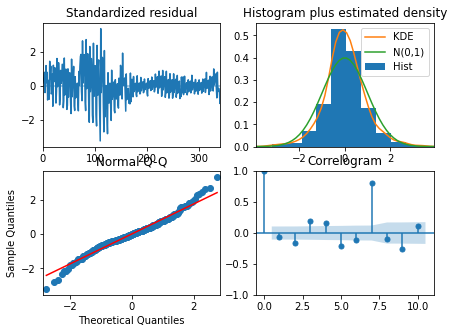

In [57]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

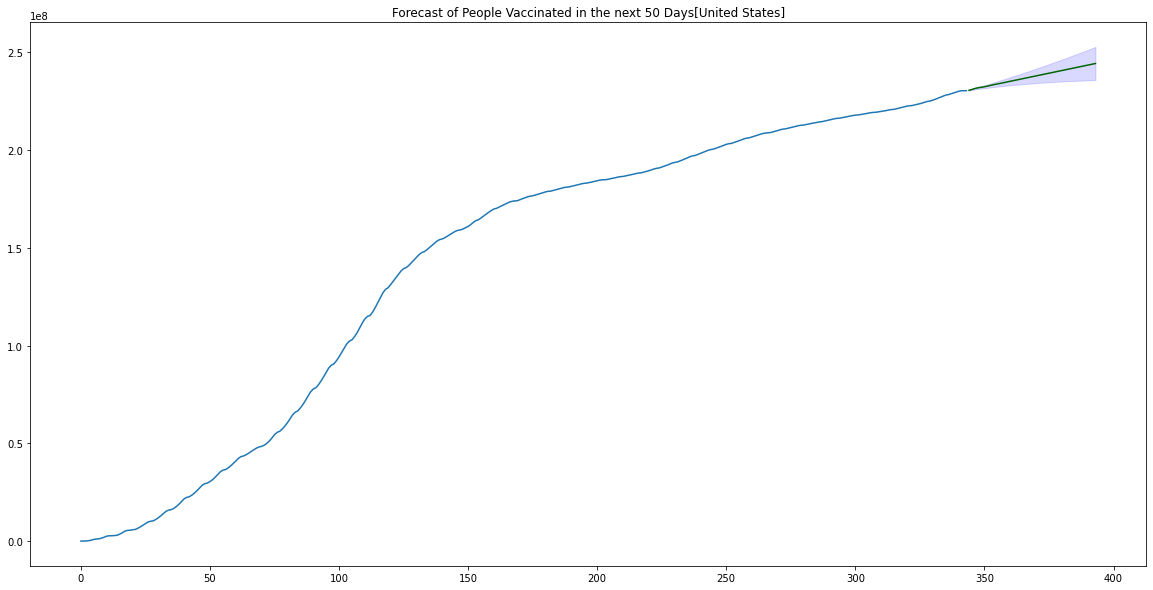

In [58]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.6)
index_of_fc = np.arange(len(val_usa), len(val_usa)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(20,10))
plt.plot(val_usa)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of People Vaccinated in the next 50 Days[United States]")
plt.show()

In [59]:
#power tramsfer
power = PowerTransformer(method='box-cox')
usa_trans = power.fit_transform(val_usa[val_usa>0].reshape(-1,1))
model = pm.auto_arima(usa_trans, trace=True, suppress_warning=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-2873.486, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-2814.895, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-2822.013, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-2831.921, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-2764.588, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-2946.517, Time=0.20 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-2813.615, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-2862.667, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-2966.571, Time=0.70 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-2878.991, Time=0.13 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-2929.708, Time=0.18 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-2875.468, Time=0.76 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-2936.966, Time=0.13 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-2987.887, Time=0.79 sec
 ARIMA(5,2,2)(0,0,0

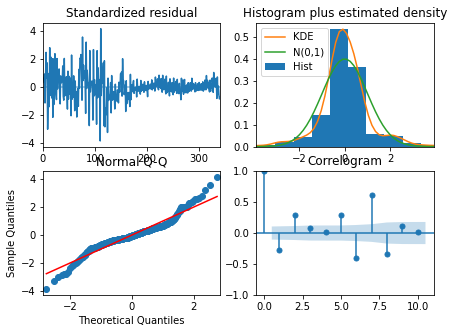

In [60]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

Similar to the Canadian model, I also tried to use power transform to change the model. But according to the plot_diagnostics, this time the transformed data's model does not get a better residual. The autocorrelation graph shows that the pattern of this model is more obvious than the autocorrelation pattern of the original data. Therefore, the optimization of this model fails, and the prediction data is no longer continued, and the prediction data obtained by the previous model will be used.

In [61]:
base_case_usa = fc[-1]-fc[0]
lower_case_usa = confint[:, 0][-1]-confint[:, 0][0]
upper_case_usa = confint[:, 1][-1]-confint[:, 1][0]
print('lower case is:',lower_case_usa,', base case is:',base_case_usa,', upper case is:',upper_case_usa)

lower case is: 5356341.65966025 , base case is: 13705404.187097102 , upper case is: 22054466.714533955


According to forecasts, the base case is that there are more than 13 millions people in USA will be vaccinated in the next 50 days, the upper case is that there are more than 22 millions people, and the lower case is that there are more than 5 millions people.

# 4. Relating COVID-19 Vaccination to a Second Dataset

## Load new dataset

In [62]:
# loading the dataset 
df2 = pd.read_csv('Complete_covid19_dataset.csv')
print('Shape of data',df.shape)
#see the first five of our dataframe
df2.head()

Shape of data (63006, 16)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [63]:
df2.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

## Canada

### Select Canada and one best factors of Vaccinated Rates 

In [64]:
#select Canada as countries
#select 'new_deaths','new_deaths_smoothed','icu_patients','hosp_patients' as the alternative columns
df_can = df2[['location', 'date','people_vaccinated_per_hundred','new_deaths','new_deaths_smoothed','icu_patients'
              ,'hosp_patients']].loc[df2.iso_code=='CAN']

In [65]:
#drop total_vaccinations missing data, because without this value any raw doesn't make much sense.
df_can = df_can.drop(df_can[df_can.people_vaccinated_per_hundred.isna()].index)

### Use Statistical Correlation(Pearson correlation, Kendall rank correlation, and Spearman correlation) to find best columns

In [66]:
df_can.corr(method='pearson')

,people_vaccinated_per_hundred,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients
people_vaccinated_per_hundred,1.000000,-0.645114,-0.718951,-0.378377,-0.670918
new_deaths,-0.645114,1.000000,0.912172,0.359297,0.735601
new_deaths_smoothed,-0.718951,0.912172,1.000000,0.388133,0.791665
icu_patients,-0.378377,0.359297,0.388133,1.000000,0.835209
hosp_patients,-0.670918,0.735601,0.791665,0.835209,1.000000


In [67]:
df_can.corr(method='kendall')

,people_vaccinated_per_hundred,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients
people_vaccinated_per_hundred,1.000000,-0.434784,-0.479324,-0.255259,-0.403058
new_deaths,-0.434784,1.000000,0.672362,0.445780,0.598558
new_deaths_smoothed,-0.479324,0.672362,1.000000,0.599117,0.763463
icu_patients,-0.255259,0.445780,0.599117,1.000000,0.740898
hosp_patients,-0.403058,0.598558,0.763463,0.740898,1.000000


In [68]:
df_can.corr(method='spearman')

,people_vaccinated_per_hundred,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients
people_vaccinated_per_hundred,1.000000,-0.592139,-0.661712,-0.415821,-0.605150
new_deaths,-0.592139,1.000000,0.846349,0.630481,0.792535
new_deaths_smoothed,-0.661712,0.846349,1.000000,0.763303,0.918363
icu_patients,-0.415821,0.630481,0.763303,1.000000,0.898615
hosp_patients,-0.605150,0.792535,0.918363,0.898615,1.000000


According to all the statistical correlation results, 'new_deaths_smoothed' is the best factor of Vaccinated rate in the Canada Dataset.

In [69]:
df_can = df_can[['people_vaccinated_per_hundred','new_deaths_smoothed']]

In [70]:
can = df_can.sort_values('people_vaccinated_per_hundred')

### EDA

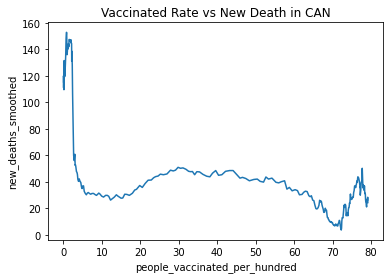

In [71]:
plt.plot(can.people_vaccinated_per_hundred,can.new_deaths_smoothed)
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed')
plt.title('Vaccinated Rate vs New Death in CAN')
plt.show()

### Implement an ML model(Linear Regression Model)

In [72]:
X = can.people_vaccinated_per_hundred
y = can.new_deaths_smoothed
#split train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [73]:
regressor = LinearRegression()  
regressor.fit(X_train.values.reshape(-1, 1), y_train)

LinearRegression()

In [74]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

86.83124408904695
[-0.90770267]


In [75]:
y_pred = regressor.predict(X.values.reshape(-1, 1))

### Result

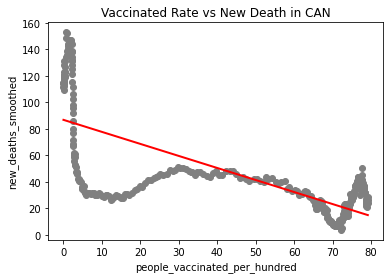

In [76]:
plt.scatter(X, y, color='gray') 
plt.plot(X, y_pred, color='red', linewidth=2) 
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed')
plt.title('Vaccinated Rate vs New Death in CAN')
plt.show()

## United States

In [77]:
#select United States as countries
#select 'new_deaths','new_deaths_smoothed','icu_patients','hosp_patients' as the alternative columns
df_usa = df2[['location', 'date','people_vaccinated_per_hundred','new_deaths','new_deaths_smoothed'
              ,'icu_patients','hosp_patients']].loc[df2.iso_code=='USA']

In [78]:
#drop total_vaccinations missing data, because without this value any raw doesn't make much sense.
df_usa = df_usa.drop(df_usa[df_usa.people_vaccinated_per_hundred.isna()].index)

### Use Statistical Correlation(Pearson correlation, Kendall rank correlation, and Spearman correlation) to find best columns

In [79]:
df_usa.corr(method='pearson')

,people_vaccinated_per_hundred,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients
people_vaccinated_per_hundred,1.000000,-0.533759,-0.668563,-0.351944,-0.479319
new_deaths,-0.533759,1.000000,0.820711,0.692719,0.710825
new_deaths_smoothed,-0.668563,0.820711,1.000000,0.798083,0.816408
icu_patients,-0.351944,0.692719,0.798083,1.000000,0.983900
hosp_patients,-0.479319,0.710825,0.816408,0.983900,1.000000


In [80]:
df_usa.corr(method='kendall')

,people_vaccinated_per_hundred,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients
people_vaccinated_per_hundred,1.000000,-0.251797,-0.298432,-0.162488,-0.198554
new_deaths,-0.251797,1.000000,0.634984,0.520162,0.528137
new_deaths_smoothed,-0.298432,0.634984,1.000000,0.641031,0.653935
icu_patients,-0.162488,0.520162,0.641031,1.000000,0.943546
hosp_patients,-0.198554,0.528137,0.653935,0.943546,1.000000


In [81]:
df_usa.corr(method='spearman')

,people_vaccinated_per_hundred,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients
people_vaccinated_per_hundred,1.000000,-0.321846,-0.366596,-0.136951,-0.187423
new_deaths,-0.321846,1.000000,0.819144,0.702295,0.709472
new_deaths_smoothed,-0.366596,0.819144,1.000000,0.824439,0.828391
icu_patients,-0.136951,0.702295,0.824439,1.000000,0.994686
hosp_patients,-0.187423,0.709472,0.828391,0.994686,1.000000


According to all the statistical correlation results, 'new_deaths_smoothed' is the best factor of Vaccinated rate in the United States Dataset.

In [82]:
df_usa = df_usa[['people_vaccinated_per_hundred','new_deaths_smoothed']]

In [83]:
usa = df_usa.sort_values('people_vaccinated_per_hundred')

## EDA

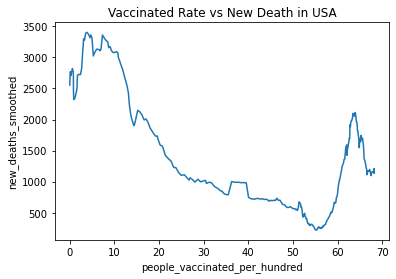

In [84]:
plt.plot(usa.people_vaccinated_per_hundred,usa.new_deaths_smoothed)
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed')
plt.title('Vaccinated Rate vs New Death in USA')
plt.show()

### Implement an ML model(Linear Regression Model)

In [85]:
X = usa.people_vaccinated_per_hundred
y = usa.new_deaths_smoothed
#split train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [86]:
regressor = LinearRegression()  
regressor.fit(X_train.values.reshape(-1, 1), y_train)

LinearRegression()

In [87]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

2513.257612983786
[-26.89544956]


In [88]:
y_pred = regressor.predict(X.values.reshape(-1, 1))

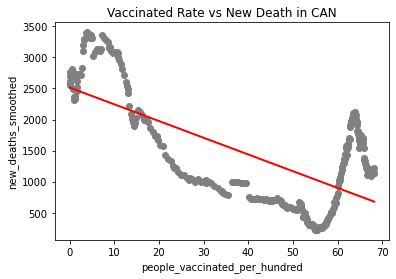

In [89]:
plt.scatter(X, y, color='gray') 
plt.plot(X, y_pred, color='red', linewidth=2) 
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed')
plt.title('Vaccinated Rate vs New Death in CAN')
plt.show()

# 5. Deriving insights about the effect of vaccination and discussion

## Result of Part 3

In the third part, according to the prediction results of the number of vaccinations in the two countries in the next 50 days, the result of the base case in the United States is 13 millions people, while the prediction result of the base case of Canada is 560,000. The result of the third part Tell me that the number of people vaccinated in the United States in the next 50 days is approximately 20 times the number in Canada. But consider the different population in these two countries, I need to remove the effect of the population.

In [90]:
#Get the population of Canada and United States
can_population = list(df2.population.loc[df2.iso_code=='CAN'])[0]
usa_population = list(df2.population.loc[df2.iso_code=='USA'])[0]

In [91]:
can_vacc_rate = base_case_can/can_population
usa_vacc_rate = base_case_usa/usa_population

In [92]:
print('Canada predict vaccinated rate is',can_vacc_rate,', United States predict vaccinated rate is',usa_vacc_rate)

Canada predict vaccinated rate is 0.014920338529705743 , United States predict vaccinated rate is 0.04116786909774203


After dividing the forecast number by the country’s population, the result of the United States is still higher than that of Canada. Now, I can say that the United States' vaccinated program is more effective.

## Result of Part 4

According to the statistical results of the vaccination rate and the new death of the two countries in the fourth part tells me that one of the most relevant factors for vaccination rates is the new mortality rate. Comparing the results of the statistical results, the correlation between the new death and the vaccination rate in Canada is stronger than the United States.

When analyzing the correlation between the number of new deaths and vaccination rates in Canada and the United States by machine learning model, it was found that the absolute value of the slope of the fitted line obtained by linear regression in the United States was larger. This shows that with the implementation of the US vaccine program, the new mortality rate in the United States has fallen faster. 

## Conclusion

Overall, the part 3 and part 4 results both illustrate that the United States' vaccinated program is more effective. In addition, part 4 proved that the most correlation factor in Complete_covid19_dataset.csv is new_deaths_smoothed.